In [30]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, nltk, spacy, gensim

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc 

# Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



from pprint import pprint
%matplotlib inline

In [6]:
# import the complete and cleaned data
df = pd.read_csv('./data/complete_clean_text.csv')
df.head()

,district_report,date,district,rate,rate_change,is_up,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,clean_text
0,\n\r\n var ref = document.referrer;\r\n ...,2019-04,at,2.532381,NaN,0,0,1.0,0.6633,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic sixth business indicated economic con...
1,\n\r\n var ref = document.referrer;\r\n ...,2019-03,at,2.570952,0.015231,1,1,1.0,0.6734,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'economic', ...",economic sixth business reported economic cont...
2,\n\r\n var ref = document.referrer;\r\n ...,2019-01,at,2.713810,0.055566,1,2,1.0,0.6796,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'remain', 'l...",economic sixth business remained largely posit...
3,\n\r\n var ref = document.referrer;\r\n ...,2018-12,at,2.832632,0.043784,1,3,1.0,0.6348,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'describe', ...",economic reports sixth business described econ...
4,\n\r\n var ref = document.referrer;\r\n ...,2018-10,at,3.152273,0.112842,1,4,1.0,0.6380,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic reports sixth business indicated econ...


In [7]:
# convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
df.head()

,district_report,date,district,rate,rate_change,is_up,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,clean_text
0,\n\r\n var ref = document.referrer;\r\n ...,2019-04-01,at,2.532381,NaN,0,0,1.0,0.6633,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic sixth business indicated economic con...
1,\n\r\n var ref = document.referrer;\r\n ...,2019-03-01,at,2.570952,0.015231,1,1,1.0,0.6734,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'economic', ...",economic sixth business reported economic cont...
2,\n\r\n var ref = document.referrer;\r\n ...,2019-01-01,at,2.713810,0.055566,1,2,1.0,0.6796,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'remain', 'l...",economic sixth business remained largely posit...
3,\n\r\n var ref = document.referrer;\r\n ...,2018-12-01,at,2.832632,0.043784,1,3,1.0,0.6348,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'describe', ...",economic reports sixth business described econ...
4,\n\r\n var ref = document.referrer;\r\n ...,2018-10-01,at,3.152273,0.112842,1,4,1.0,0.6380,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic reports sixth business indicated econ...


In [8]:
# declare the dataset as a timeseries
df.set_index('date', inplace=True)

In [9]:
df.head()

,district_report,district,rate,rate_change,is_up,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,clean_text
date,,,,,,,,,,,
2019-04-01,\n\r\n var ref = document.referrer;\r\n ...,at,2.532381,NaN,0,0,1.0,0.6633,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic sixth business indicated economic con...
2019-03-01,\n\r\n var ref = document.referrer;\r\n ...,at,2.570952,0.015231,1,1,1.0,0.6734,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'economic', ...",economic sixth business reported economic cont...
2019-01-01,\n\r\n var ref = document.referrer;\r\n ...,at,2.713810,0.055566,1,2,1.0,0.6796,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'remain', 'l...",economic sixth business remained largely posit...
2018-12-01,\n\r\n var ref = document.referrer;\r\n ...,at,2.832632,0.043784,1,3,1.0,0.6348,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'describe', ...",economic reports sixth business described econ...
2018-10-01,\n\r\n var ref = document.referrer;\r\n ...,at,3.152273,0.112842,1,4,1.0,0.6380,"increase, price, demand, estate, service, real...","['economic', 'sixth', 'business', 'indicate', ...",economic reports sixth business indicated econ...


In [141]:
labels = y

## Preprocessing (getting ready for modeling)

In [253]:
embedding_dim = 100 
max_words = 10000

np.random.seed(20190514)

maxlen = 500 
training_samples = 1000 
test_samples = 10000 
max_words = 10000

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(df['Text']) 
sequences = tokenizer.texts_to_sequences(df['Text'])

word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels) 
print('Shape of data tensor:', data.shape) 
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0]) 
np.random.shuffle(indices) 
data = data[indices] 
labels = labels[indices]

Found 14807 unique tokens.
Shape of data tensor: (5148, 500)
Shape of label tensor: (5148,)


In [254]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_test = data[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]

## Parsing the GloVe word-embeddings file

Go [here](https://nlp.stanford.edu/projects/glove) to download the pre-trained embeddings from 2014 English Wikipedia.

In [56]:
import os

In [57]:
# imports the embeddings
glove_dir = './resources/glove.6B'

In [255]:
# builds an index that maps words (as strings) as number vectors
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Preparing the GloVe word-embeddings matrix

In [256]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # words not found in the embedding index will be all zeros
            
            

## Defining the Model

In [60]:
# Model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [118]:
# setting up the model architecture 
model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x155215e10>>

## Loading the GloVe Embeddings in the Model

In [119]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Training and Evaluating the Model

In [120]:
# compile and train the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_data=(X_test, y_test))

model.save_weights('pre_trained_glove_model.h5')

Train on 700 samples, validate on 4448 samples
Epoch 1/50
700/700 [==============================] - 1s 1ms/step - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6930 - val_acc: 0.5054
Epoch 2/50
700/700 [==============================] - 0s 223us/step - loss: 0.6899 - acc: 0.5271 - val_loss: 0.6930 - val_acc: 0.5063
Epoch 3/50
700/700 [==============================] - 0s 221us/step - loss: 0.6883 - acc: 0.5271 - val_loss: 0.6930 - val_acc: 0.5063
Epoch 4/50
700/700 [==============================] - 0s 212us/step - loss: 0.6863 - acc: 0.5271 - val_loss: 0.6931 - val_acc: 0.5058
Epoch 5/50
700/700 [==============================] - 0s 226us/step - loss: 0.6852 - acc: 0.5271 - val_loss: 0.6932 - val_acc: 0.5058
Epoch 6/50
700/700 [==============================] - 0s 203us/step - loss: 0.6844 - acc: 0.5271 - val_loss: 0.6933 - val_acc: 0.5056
Epoch 7/50
700/700 [==============================] - 0s 200us/step - loss: 0.6838 - acc: 0.5271 - val_loss: 0.6934 - val_acc: 0.5056
Epoch 8/50
700/70

## Plotting the results

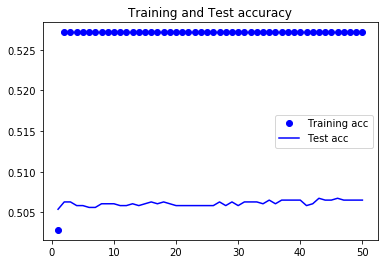

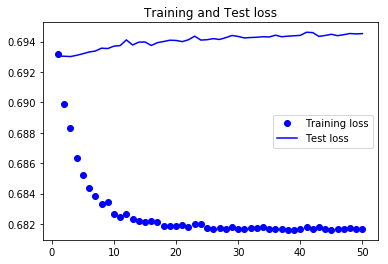

In [121]:
# plotting the training and test scores
train_acc = history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

The model overfits very quickly. The model performs relatively worse on unseen data. The accuracy of the model suggests that our model does not do better than a guess. 
We will attempt to address this in a number of ways presented below.

## Training the same model without pretrained word embeddings

In [122]:
model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(X_test, y_test))

Train on 200 samples, validate on 4948 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6960 - acc: 0.4400 - val_loss: 0.6936 - val_acc: 0.4899
Epoch 2/10
200/200 [==============================] - 0s 948us/step - loss: 0.5772 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.4923
Epoch 3/10
200/200 [==============================] - 0s 925us/step - loss: 0.4753 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.5032
Epoch 4/10
200/200 [==============================] - 0s 763us/step - loss: 0.3416 - acc: 1.0000 - val_loss: 0.6976 - val_acc: 0.5040
Epoch 5/10
200/200 [==============================] - 0s 904us/step - loss: 0.1872 - acc: 1.0000 - val_loss: 0.7033 - val_acc: 0.5006
Epoch 6/10
200/200 [==============================] - 0s 832us/step - loss: 0.0786 - acc: 1.0000 - val_loss: 0.7113 - val_acc: 0.5028
Epoch 7/10
200/200 [==============================] - 0s 743us/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.7229 - val_acc: 0.5042
Epoch 8/10
200/20

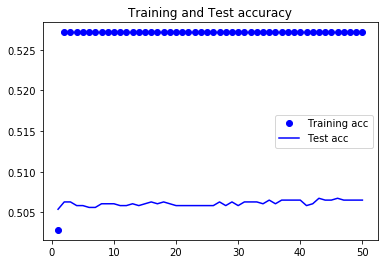

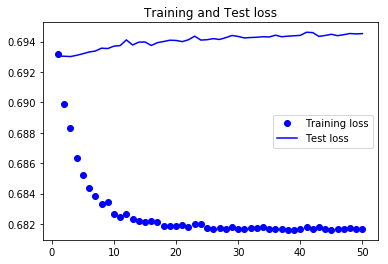

In [123]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

We do not observe any significant difference between the model with embeddings and the one without.
Next, we turn to a Recurrent Neural Networ to see if we can do better.

## RNN (Using an LSTM layer)

In [124]:
from keras.layers import LSTM

In [133]:
batch_size = 32

In [134]:
model = Sequential()

model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [135]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 6s 4ms/step - loss: 0.6932 - acc: 0.5112 - val_loss: 0.6909 - val_acc: 0.5425
Epoch 2/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.6897 - acc: 0.5175 - val_loss: 0.6909 - val_acc: 0.5450
Epoch 3/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.6835 - acc: 0.6331 - val_loss: 0.6911 - val_acc: 0.5400
Epoch 4/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.6657 - acc: 0.6975 - val_loss: 0.6928 - val_acc: 0.5100
Epoch 5/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.6138 - acc: 0.7575 - val_loss: 0.7152 - val_acc: 0.4975
Epoch 6/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.5026 - acc: 0.8006 - val_loss: 0.7917 - val_acc: 0.4875
Epoch 7/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.3859 - acc: 0.8506 - val_loss: 0.8352 - val_acc: 0.4950
Epoch 8/10
1600

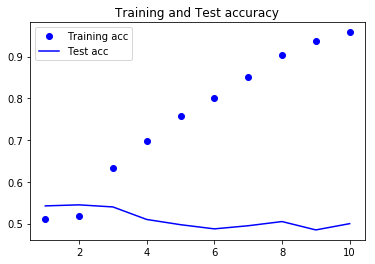

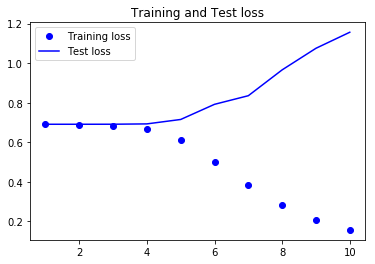

In [136]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

Although we have a high accuracy score, we find that the model overfits again. 

## Regularization

In [238]:
from keras import regularizers

In [247]:
model_dropout = Sequential()

model_dropout.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_dropout.add(Flatten())
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1, activation='sigmoid'))
model_dropout.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x157cc5080>>

In [248]:
model_dropout.layers[0].set_weights([embedding_matrix])
model_dropout.layers[0].trainable = False

In [249]:
# compile and train the model
model_dropout.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

history_dropout = model_dropout.fit(X_train, y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test))

Train on 1000 samples, validate on 4148 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6933 - acc: 0.4750 - val_loss: 0.6933 - val_acc: 0.5096
Epoch 2/10
1000/1000 [==============================] - 0s 495us/step - loss: 0.6855 - acc: 0.5190 - val_loss: 0.6935 - val_acc: 0.4899
Epoch 3/10
1000/1000 [==============================] - 0s 494us/step - loss: 0.6770 - acc: 0.5560 - val_loss: 0.6941 - val_acc: 0.4882
Epoch 4/10
1000/1000 [==============================] - 0s 495us/step - loss: 0.6705 - acc: 0.5540 - val_loss: 0.6947 - val_acc: 0.4875
Epoch 5/10
1000/1000 [==============================] - 1s 513us/step - loss: 0.6637 - acc: 0.5540 - val_loss: 0.6959 - val_acc: 0.4867
Epoch 6/10
1000/1000 [==============================] - 1s 541us/step - loss: 0.6584 - acc: 0.5530 - val_loss: 0.6965 - val_acc: 0.4875
Epoch 7/10
1000/1000 [==============================] - 1s 512us/step - loss: 0.6549 - acc: 0.5470 - val_loss: 0.6975 - val_acc: 0.4879
Ep

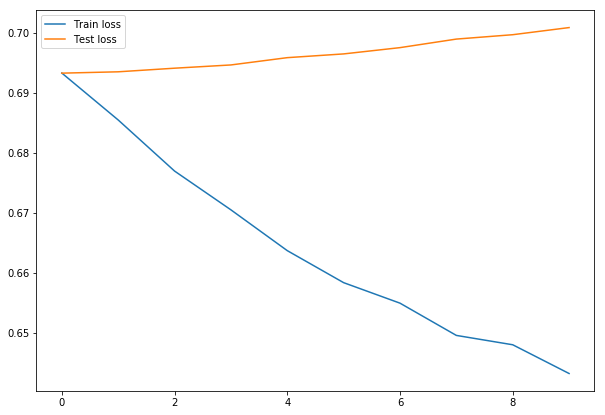

In [250]:
plt.figure(figsize=(10,7))
plt.plot(history_dropout.history['loss'], label='Train loss')
plt.plot(history_dropout.history['val_loss'], label='Test loss')
plt.legend();

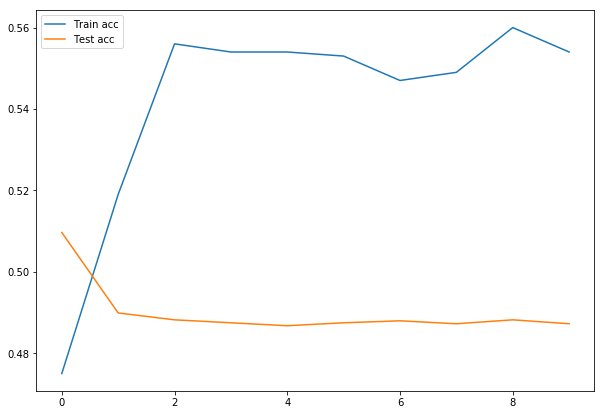

In [251]:
plt.figure(figsize=(10,7))
plt.plot(history_dropout.history['acc'], label='Train acc')
plt.plot(history_dropout.history['val_acc'], label='Test acc')
plt.legend();

In [259]:
model_dropout = Sequential()

model_dropout.add(Embedding(max_features, 32))
model_dropout.add(LSTM(32))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1, activation='sigmoid'))

In [260]:
model_dropout.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history_dropout = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/step - loss: 0.6874 - acc: 0.5600 - val_loss: 0.6957 - val_acc: 0.4800
Epoch 2/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6818 - acc: 0.5750 - val_loss: 0.6972 - val_acc: 0.4850
Epoch 3/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6721 - acc: 0.6062 - val_loss: 0.6995 - val_acc: 0.4900
Epoch 4/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6547 - acc: 0.7125 - val_loss: 0.7025 - val_acc: 0.4600
Epoch 5/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6213 - acc: 0.8150 - val_loss: 0.7209 - val_acc: 0.4850
Epoch 6/10
800/800 [==============================] - 3s 3ms/step - loss: 0.5689 - acc: 0.7950 - val_loss: 0.7128 - val_acc: 0.4800
Epoch 7/10
800/800 [==============================] - 3s 3ms/step - loss: 0.5104 - acc: 0.8925 - val_loss: 0.7449 - val_acc: 0.5100
Epoch 8/10
800/800 [==========

We do not observe any changes in the model's performance after regularization.
Next, we explicitly account for time in the model.

## Explicitly Incorporating Time

The Beige books and the interest rates are not time invariant. Therefore, we attempt to model this assumed relationship by explicitly accounting for time. 

### Train/Test Split 

In [181]:
# Create X and y
features = ['clean_text'] 
X = df[features] 
y = df['is_up'].values

In [182]:
# Train/Test Split
# since this is a time series, we do not shuffle observations in the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 
X_train.head()

,clean_text
date,
2019-04-01,economic sixth business indicated economic con...
2019-03-01,economic sixth business reported economic cont...
2019-01-01,economic sixth business remained largely posit...
2018-12-01,economic reports sixth business described econ...
2018-10-01,economic reports sixth business indicated econ...


In [183]:
X_train.shape

(3861, 1)

In [184]:
X_test.shape

(1287, 1)

In [198]:
# vectorize the data
tvec = TfidfVectorizer(analyzer='word',
                       #stop_words='english',
                       ngram_range= (2, 3),
                      max_features=1000)

In [199]:
X_train_vec = tvec.fit_transform(X_train['clean_text'])
X_test_vec = tvec.transform(X_test['clean_text'])

In [200]:
X_train_vec.shape

(3861, 1000)

In [206]:
X_test_vec.shape

(1287, 1000)

In [203]:
feature_names = tvec.get_feature_names()

In [217]:
train_X = X_train_vec.todense()
test_X = X_test_vec.todense()

In [218]:
# Create training sequences
train_sequences = TimeseriesGenerator(train_X, y_train, 
                                      length=3, # prior 3 months
                                      batch_size=64)

In [219]:
# Create test sequences
test_sequences = TimeseriesGenerator(test_X, y_test,
                                    length=3,
                                    batch_size=64)

In [220]:
train_sequences[0][0].shape

(64, 3, 1000)

In [224]:
# Design RNN architecture
model = Sequential()

model.add(GRU(
    16,
    input_shape=(3, 1000), # 3 rows, 1000 columns each
    return_sequences=True  # if the next layer is also RNN 
))

model.add(GRU(
    16,
    return_sequences=False  # False if the next layer is Dense
))

model.add(Dense(
    8, 
    activation='relu'
))

model.add(Dense(
    1, 
    activation='sigmoid'
))

In [225]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0005),
    metrics=['accuracy'])

In [226]:
history = model.fit_generator(train_sequences,  # fit method differs for TimeseriesGen
                    validation_data=test_sequences, 
                    epochs=10)

Epoch 1/10
61/61 [==============================] - 3s 44ms/step - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6928 - val_acc: 0.5179
Epoch 2/10
61/61 [==============================] - 0s 7ms/step - loss: 0.6908 - acc: 0.5593 - val_loss: 0.6910 - val_acc: 0.5093
Epoch 3/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6845 - acc: 0.5602 - val_loss: 0.6856 - val_acc: 0.5561
Epoch 4/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6716 - acc: 0.6142 - val_loss: 0.6775 - val_acc: 0.5615
Epoch 5/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6499 - acc: 0.6309 - val_loss: 0.6756 - val_acc: 0.5584
Epoch 6/10
61/61 [==============================] - 0s 7ms/step - loss: 0.6252 - acc: 0.6596 - val_loss: 0.6897 - val_acc: 0.5600
Epoch 7/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6046 - acc: 0.6763 - val_loss: 0.6963 - val_acc: 0.5639
Epoch 8/10
61/61 [==============================] - 0s 7ms/step - loss: 0.5976 - acc: 0.6

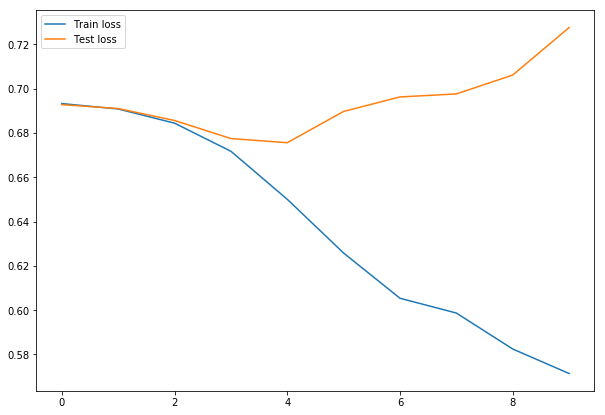

In [227]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

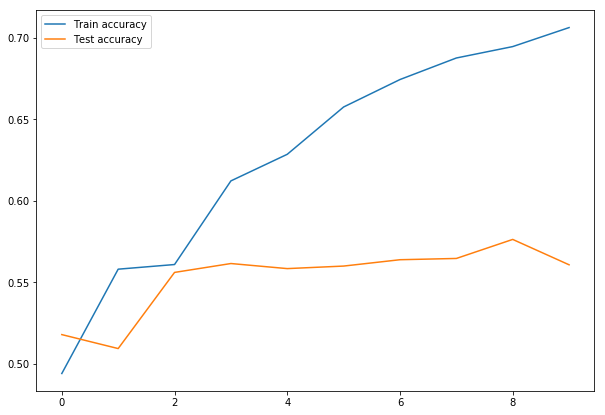

In [228]:
plt.figure(figsize=(10,7))
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

The model begins to overfit just after two epochs. Again, the model overfits.

In [229]:
# generates predictions for the input samples
model.predict_generator(test_sequences)

array([[0.17348483],
       [0.20628566],
       [0.17866185],
       ...,
       [0.64244074],
       [0.7069046 ],
       [0.7419022 ]], dtype=float32)

## Parametric Modeling

We have used methods that assume no functional form. As we saw from the previous models, more flexible models require estimating a greater number of parameters. Now, we turn to less flexible since we observe high overfitting in the previous models. 

In [278]:
# Create X and y
#features = ['Text'] 
X = df['Text'] 
y = df['is_up']

In [279]:
X.shape

(5148,)

In [280]:
y.shape

(5148,)

In [281]:
y.value_counts(normalize=True)

1    0.508159
0    0.491841
Name: is_up, dtype: float64

In [286]:
def classifier(X, y, estimator, random_state=20190515):
    
    '''
    A function that takes 4 arguments: an n x 1 predictor vector, 
    an n x 1 target vector, an estimator, and sets a random state.
    
    It trains tests splits the data, uses a pipeline, performs a
    grid search for optimal hyperparameters, calculates evaluation
    metrics and returns a classification report and an roc-auc curve.
    '''
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = .40, 
                                                        stratify=y,
                                                       random_state=20190515)
    
    
    pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('clf', estimator)
    ])

    pipe_params = {
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'tvec__max_features': [500, 1000, 2000],
    #'tvec__min_df': [1, 2, 3],
    #'tvec__max_df': [1.0, 0.8, 0.6]
    }

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

    gs.fit(X_train, y_train)

    #print(f'The Accuracy score is: {round(gs.score(X_train, y_train), 2)}')

    print(gs.best_params_)
    print(f'The cross_val_score is: {round(gs.best_score_, 2)}')
    #y_predpr_lr = gs.best_estimator_.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, gs.best_estimator_.predict(X_test)).ravel()



    accuracy = round((tn + tp) / (tn + fp + fn + tp), 2)
    misclassification = round((1 - accuracy), 2)
    sensitivity = round((tp) / (tp + fn), 2)
    specificity = round((tn) / (tn + fp), 2)
    precision = round((tp) / (tp + fp), 2)

    print(f'The Accuracy is: {accuracy}')
    print(f'The Missclassification Rate is: {misclassification}')
    print(f'The Sensitivity/Recall is: {sensitivity}')
    print(f'The Specificity is: {specificity}')
    print(f'The Precision is: {precision}')


    fpr_clf, tpr_clf, _ = roc_curve(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    plt.figure(figsize = (10, 7))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_clf, tpr_clf, lw=3, label='The ROC curve (area = {:0.2f})'.format(roc_auc_clf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (10 Year Bond Rates)', fontsize=18)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    print(classification_report(y_test, gs.best_estimator_.predict(X_test)))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'tvec__max_features': 500, 'tvec__ngram_range': (1, 2)}
The cross_val_score is: 0.54
The Accuracy is: 0.54
The Missclassification Rate is: 0.46
The Sensitivity/Recall is: 0.59
The Specificity is: 0.49
The Precision is: 0.55
              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1013
           1       0.55      0.59      0.57      1047

   micro avg       0.54      0.54      0.54      2060
   macro avg       0.54      0.54      0.54      2060
weighted avg       0.54      0.54      0.54      2060



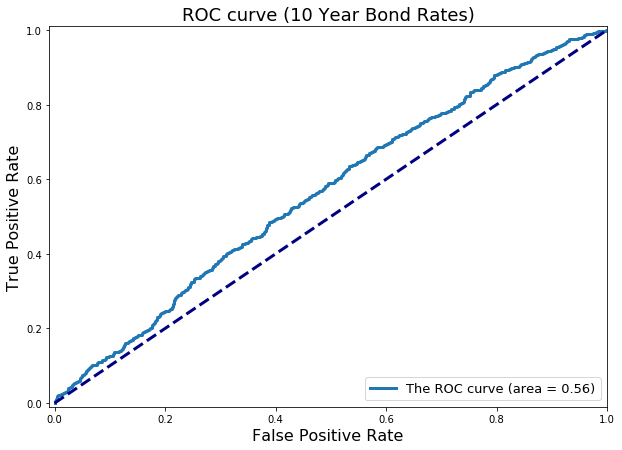

In [287]:
classifier(X, y, 
           LogisticRegression(), 
           random_state=20190515)

The Logistic regression model (and the Naive Bayes model not displyed here) does not perform any better than the Neural Network algorithms. This suggests that predicting interest rate movements may require more **X** features. That is, our model may not include other variables that account for the variation in our dependent variable.